# <u>Stopped-Flow SANS experiment template</u>

## Table of Contents

* [1. System initialization](#step1)
    * [1a. Input the path to the device configuration files as device_config](#step1a)
    * [1b. Input the COM ports selector and switch valves](#step1b)
    * [1c. Select and assign syringe type to be used](#step1c)
    * [1d. Detach all syringes and calibrate all pumps](#step1d)
* [2. Insert empty syringes and adjust syringe mount head position](#step2)
* [3. Connecting, checking, and priming system lines](#step3)
    * [3a. Check ports and connections](#step3a)
    * [3b. Calculate the void volumes](#step3b)
    * [3c. Priming pumps, valves, and tubing with sample, solvent, or buffer](#step3c)
    * [3d. Purging air from pump, valves, tubing, mixer, and sample cells](#step3d)
* [4. Stopped-flow experiment procedure](#step4)
    * [4a. Define and test the rinsing/drying protocol before sample injection](#step4a)
    * [4b. Define all stopped-flow parameters](#step4b)
    * [4c. Start SANS event mode data collection](#step4c)
    * [4d. Start stopped-flow mixing experiment](#step4d)
    * [4e. Collect SANS transmission measurement](#step4e)
* [5. Time binning event mode data](#step5)
    * [5a. Import event data for SANS .nxs file](#step5a)
    * [5b. Plot the time-stamped neutron counts](#step5b)
    * [5c. Define time bin edges and bin the data](#step5c)
    * [5d. Reduced the time binned data using SANS reduction procedures](#step5d)  
* [6. Shutdown](#step6)
    

This notebook provides an example of the stopped-flow SANS experiment performed on the VSANS instrument at the NIST Center for Neutron Research (NCNR) to study the exchange kinetics of lipid vesicles.

The experiment protocol must also be updated each time a physical change is made to the pump configurations, valve configurations, or tubing connections between ports. Certain sections of this template notebook must be updated to work properly on different PCs. 

This protocol uses the QmixSDK (software development kit) available from Cetoni, which is used to control Cetoni syringe pumps. Use of QmixSDK requires a configuration file for the bus and pump identifications, which is created using Cetoni's QmixElements software. Modifications should be made to the pump configuration file when using a different collection of Cetoni pumps.  New pump commands will be needed if using entirely different syringe pumps.

This protocol uses flow selector valves and switches to control the flow of samples and solvents from the syringe pumps to the mixer and sample cells. New valve commands will be needed when using different flow selector valves. 

A repository for Python based code to control Vici selector valves, as well as Python based code to download and time-slice event mode data obtained at the NCNR, are available at https://github.com/usnistgov/stopped-flow-sans.

The image below shows the different components involved in stopped-flow SANS measurement.

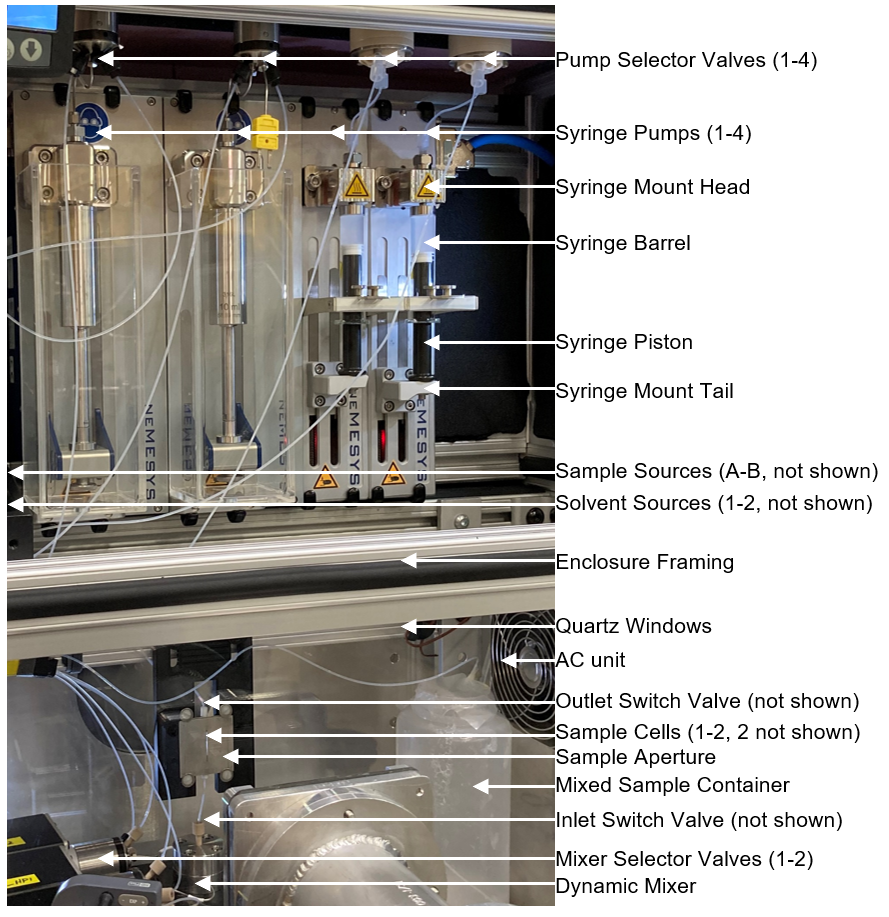

The diagram below (a) shows the tubing, valve, and pump connections used in this notebook example. If the fluid connections are changed, then corresponding changes to the notebook must be made to ensure safe operation. This example will walk through steps to perform automated stopped-flow measurements including (a) injection, (b) stopping flow, (c) solvent rinsing, and (d) drying.

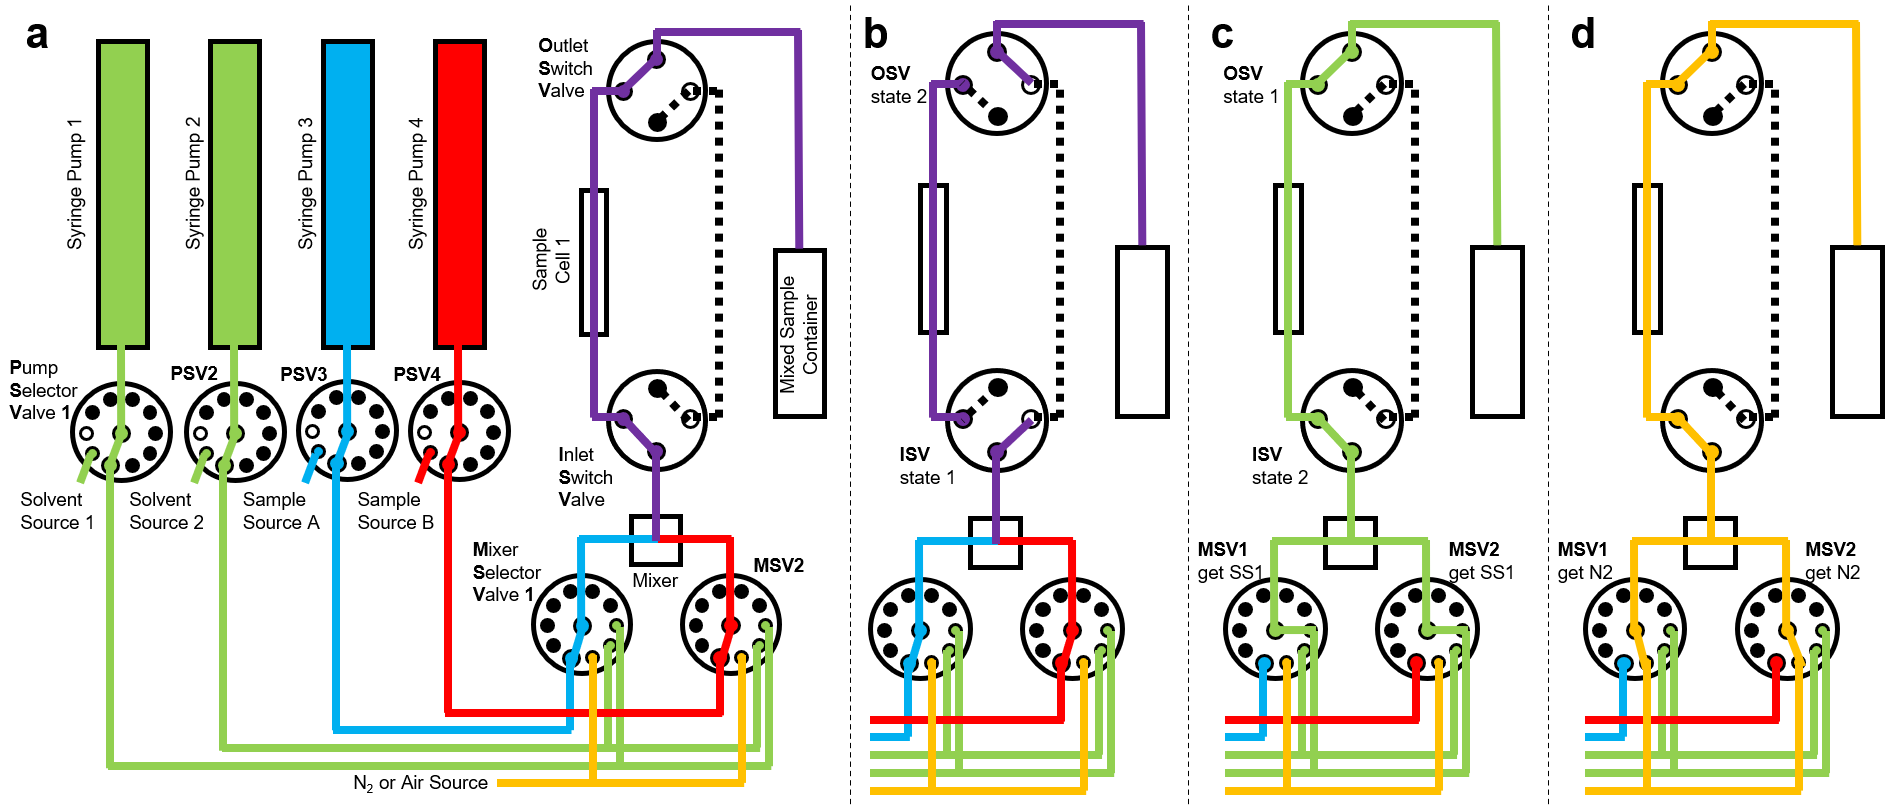

An example of the "raw" neutron count rates collected on the NG3 VSANS instrument (middle detector carraige) is shown below in (a) for an experiment with repeated rinsing steps, a drying step, and a sample injection step. This experiment can be repeated multiple times to acquire sufficient scattered neutron counting statistics to extract kinetic paramters. An example of a lipid exchange experiment is shown in (b), where a decay in neutron counts is observed after stopping the flow. By collecting all stopped-flow measurement data in 'event mode', one can arbitrarily slice neutron scattering data into different time bins after the mixing experiment to extract the rate parameters.

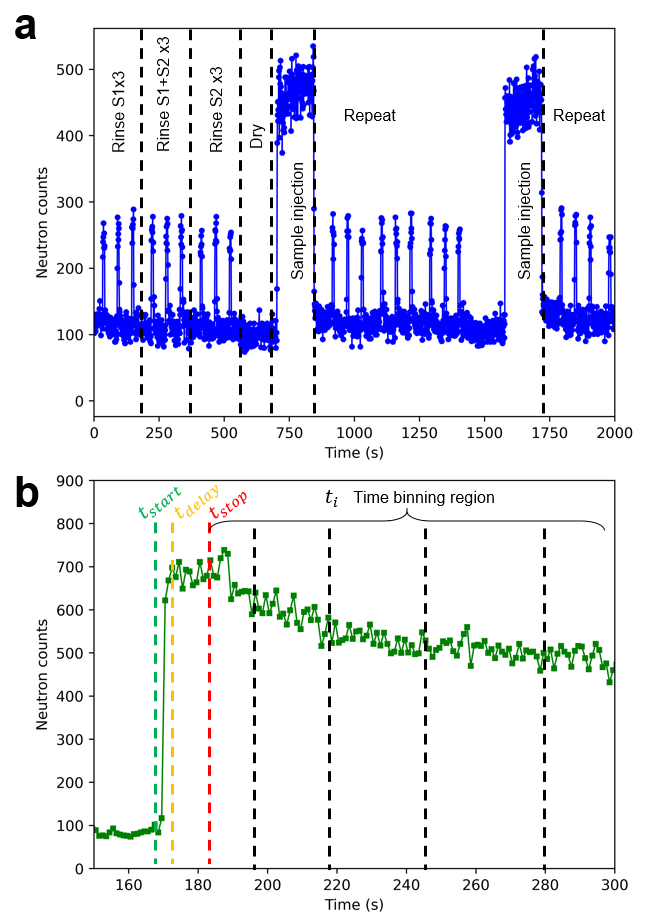

# 1. System initialization <a class="anchor" id="step1"></a>

Ensure that you are running this notebook in the same working directory that contains all QmixSDK .dll files and other Python scripts.

In [ ]:
#change this working directory to where the QmixSDK folder is installed
qmixsdk_dir = "C:/QmixSDK" 

In [ ]:
#import all relevant modules
import sys
import os
sys.path.append(qmixsdk_dir + "/lib/python")
os.environ['PATH'] += os.pathsep + qmixsdk_dir

import serial
import numpy
import time
from ViciMultiposSelector import *
from PyDAQmx import *
from ctypes import *

from qmixsdk import qmixbus
from qmixsdk import qmixpump
from qmixsdk import qmixanalogio
from qmixsdk.qmixbus import UnitPrefix, TimeUnit
from qmixsdk.qmixpump import VolumeUnit

### 1a. Input the path to the device configuration files as device_config <a class="anchor" id="step1a"></a>

Change device_config to path where the Cetoni configuration file is located for the pumps you wish to control

In [ ]:
device_config = 'C:\\Users\\Public\\Documents\\QmixElements\\Projects\\HP1_HP2_MP3_MP4\\Configurations\\HP1_HP2_MP1_MP2'

Look up the number of pumps associated with the above configuration file. Ensure the configuration file coincides with the actual pump and bus connections currently connected.

In [ ]:
print("Opening bus with device configuration ", device_config)
bus = qmixbus.Bus()
bus.open(device_config, 0)
print("Looking up devices...")
pumpcount = qmixpump.Pump.get_no_of_pumps()
print("Number of pumps: ", pumpcount)
for i in range(pumpcount):
    pump = qmixpump.Pump()
    pump.lookup_by_device_index(i)
    print("Name of pump ", i, " is ", pump.get_device_name())

Assign pump names (e.g. pump0, pump1...) to the available pumps listed above

In [ ]:
#ensure the pump names correspond to the pumps you wish to control
pump1=qmixpump.Pump()
pump1.lookup_by_device_index(0)
print('pump1 is ', pump1.get_device_name())

pump2=qmixpump.Pump()
pump2.lookup_by_device_index(1)
print('pump2 is ', pump2.get_device_name())

pump3=qmixpump.Pump()
pump3.lookup_by_device_index(2)
print('pump3 is ', pump3.get_device_name())

pump4=qmixpump.Pump()
pump4.lookup_by_device_index(3)
print('pump4 is ', pump4.get_device_name())

pump_list = [pump1, 
             pump2, 
             pump3, 
             pump4
            ]

Start bus communications

In [ ]:
print("Starting bus communication...")
bus.start()
print("Bus started.")

Enable the pump drives for pumps given in the pump_list defined above

In [ ]:
for pump in pump_list:
    print('Enabling pump drive for', pump.get_device_name())
    if pump.is_in_fault_state():
        pump.clear_fault()
    assert(not pump.is_in_fault_state())
    if not pump.is_enabled():
        pump.enable(True)
    assert(pump.is_enabled())
    print(str(pump) + ' drive enabled.')

### 1b. Input the COM ports selector and switch valves <a class="anchor" id="step1b"></a>
Ensure that valve0 connected to pump0, valve1 connected to pump1, etc.

Double check that the COM ports associated with the valves are correct (i.e., test each valve movement before running experiment)

In [ ]:
pump_selector_valve1 = ViciMultiposSelector('COM1', baud=9600, valvetype='Vici low pressure multiport') 
pump_selector_valve2 = ViciMultiposSelector('COM2', baud=9600, valvetype='Vici low pressure multiport') 
pump_selector_valve3 = ViciMultiposSelector('COM1', baud=9600, valvetype='Vici low pressure multiport') 
pump_selector_valve4 = ViciMultiposSelector('COM2', baud=9600, valvetype='Vici low pressure multiport') 
mixer_selector_valve1 = ViciMultiposSelector('COM5', baud=9600, valvetype='Vici high pressure multiport') 
mixer_selector_valve2 = ViciMultiposSelector('COM6', baud=9600, valvetype='Vici high pressure multiport')
inlet_switch_valve = ViciMultiposSelector('COM7', baud=9600, valvetype='Vici high pressure switch') 
outlet_switch_valve = ViciMultiposSelector('COM8', baud=9600, valvetype='Vici high pressure switch')

Update the valve list to include the above valves, or any valves you wish to control

In [ ]:
#when using Vici valves, check that the valve ID is set to * (none). If set to *ID*, then the serial command will reset ID
valve_list = [pump_selector_valve1, 
              pump_selector_valve2,
              pump_selector_valve3,
              pump_selector_valve4,
              mixer_selector_valve1, 
              mixer_selector_valve2, 
              inlet_switch_valve, 
              outlet_switch_valve
             ]

for valve in valve_list:
    print(str(valve) + 'positions:', valve.npositions)

Ensure that each valve sequentially changes to <code>testport2</code>, in the order listed in <code>valve_list</code>. Then, ensure each valve sequentially changes back to <code>testport1</code>. If the incorrect valve moves, then check the COM port connections and reinitialize the valves.

In [ ]:
#Test the valve switching to ensure they work and respond to the correct port
testport1 = 1
testport2 = 2
sleep_time = 3 #s

for valve in valve_list:
    time.sleep(sleep_time)
    valve.selectPort(testport2)
    
time.sleep(sleep_time)
   
for valve in valve_list:
    assert (valve.getPort()==testport2)

for valve in valve_list:
    time.sleep(sleep_time)
    valve.selectPort(testport1)

time.sleep(sleep_time)

for valve in valve_list:
    assert (valve.getPort()==testport1)

print('Valves initialized.')

### 1c. Select and assign syringe type to be used <a class="anchor" id="step1c"></a>
Determine the type of syringes to be used from the example dictionary below. This is an example list of stainless steel and glass syringes, each with specified inner diameter, max piston stroke length, fill volume, max pressure, min and max temperatures. Other syringes can be added to this dictionary as needed.


In [ ]:
syringes = {'3 mL steel HP': dict(inner_diameter_mm=8.00289,
                                  max_piston_stroke_mm=61,
                                  fill_volume_mL=3,
                                  max_pressure_bar=517,
                                  max_temperature_degC=50,
                                  min_temperature_degC=0),
            
            '10 mL steel HP': dict(inner_diameter_mm=14.704,
                                   max_piston_stroke_mm=61,
                                   fill_volume_mL=10,
                                   max_pressure_bar=153,
                                   max_temperature_degC=50,
                                   min_temperature_degC=0),
            
            '3 mL steel MP': dict(inner_diameter_mm=8.00289,
                                  max_piston_stroke_mm=61,
                                  fill_volume_mL=3,
                                  max_pressure_bar=199,
                                  max_temperature_degC=50,
                                  min_temperature_degC=0),
            
            '50 mL steel MP': dict(inner_diameter_mm=35.0199,
                                   max_piston_stroke_mm=60,
                                   fill_volume_mL=50,
                                   max_pressure_bar=10,
                                   max_temperature_degC=50,
                                   min_temperature_degC=0),
            
            '0.01 mL glass Hamilton': dict(inner_diameter_mm=0.460,
                                           max_piston_stroke_mm=60,
                                           fill_volume_mL=0.01,
                                           max_pressure_bar=68.9,
                                           max_temperature_degC=115,
                                           min_temperature_degC=10),
            
            '0.1 mL glass Hamilton': dict(inner_diameter_mm=1.46,
                                          max_piston_stroke_mm=60,
                                          fill_volume_mL=0.1,
                                          max_pressure_bar=68.9,
                                          max_temperature_degC=115,
                                          min_temperature_degC=10),
            
            '1 mL glass Hamilton': dict(inner_diameter_mm=4.61,
                                        max_piston_stroke_mm=60,
                                        fill_volume_mL=1,
                                        max_pressure_bar=13.8,
                                        max_temperature_degC=115,
                                        min_temperature_degC=10),
            
            '2.5 mL glass Hamilton': dict(inner_diameter_mm=7.29,
                                          max_piston_stroke_mm=60,
                                          fill_volume_mL=2.5,
                                          max_pressure_bar=13.8,
                                          max_temperature_degC=115,
                                          min_temperature_degC=10),
            
            '10 mL glass Hamilton': dict(inner_diameter_mm=14.6,
                                         max_piston_stroke_mm=60,
                                         fill_volume_mL=10,
                                         max_pressure_bar=13.8,
                                         max_temperature_degC=115,
                                         min_temperature_degC=10),
            
            '50 mL glass Hamilton': dict(inner_diameter_mm=32.6,
                                         max_piston_stroke_mm=60,
                                         fill_volume_mL=50,
                                         max_pressure_bar=6.9,
                                         max_temperature_degC=80,
                                         min_temperature_degC=10)
           }

Input the syringe type to be used for each pump, but do not physically attach the syringe yet. Update the <code>syringe_list</code> to contain all syringes to be used.

In [ ]:
#Input the name of the syringe types to be used from the above dictionary, syringe1 will connect to pump1, etc.
syringe1=syringes['10 mL steel HP'] #to be connected to pump1
syringe2=syringes['10 mL steel HP'] #to be connected to pump2
syringe3=syringes['1 mL glass Hamilton'] #to be connected to pump3
syringe4=syringes['1 mL glass Hamilton'] #to be connected to pump4

syringe_list = [syringe1, syringe2, syringe3, syringe4]

#This defines the inner diameter and max piston stroke so the pumps know the flow rate and when to stop the piston retraction
pump1.set_syringe_param(syringe1['inner_diameter_mm'], syringe1['max_piston_stroke_mm'])
pump1.set_flow_unit(prefix=UnitPrefix.milli, 
                    volume_unit=VolumeUnit.litres, 
                    time_unit=TimeUnit.per_minute)
print('pump1 has syringe params', syringe1)
print('pump1 has flow units', pump1.get_flow_unit())

pump2.set_syringe_param(syringe2['inner_diameter_mm'], syringe2['max_piston_stroke_mm'])
pump2.set_flow_unit(prefix=UnitPrefix.milli, 
                    volume_unit=VolumeUnit.litres, 
                    time_unit=TimeUnit.per_minute)
print('pump2 has syringe params', syringe2)
print('pump2 has flow units', pump2.get_flow_unit())

pump3.set_syringe_param(syringe3['inner_diameter_mm'], syringe3['max_piston_stroke_mm'])
pump3.set_flow_unit(prefix=UnitPrefix.milli, 
                    volume_unit=VolumeUnit.litres, 
                    time_unit=TimeUnit.per_minute)
print('pump3 has syringe params', syringe3)
print('pump3 has flow units', pump3.get_flow_unit())

pump4.set_syringe_param(syringe4['inner_diameter_mm'], syringe4['max_piston_stroke_mm'])
pump4.set_flow_unit(prefix=UnitPrefix.milli, 
                    volume_unit=VolumeUnit.litres, 
                    time_unit=TimeUnit.per_minute)
print('pump4 has syringe params', syringe4)
print('pump4 has flow units', pump4.get_flow_unit())

### 1d. Detach all syringes and calibrate all pumps <a class="anchor" id="step1d"></a>

#### <u>IMPORTANT</u>: PHYSICALLY REMOVE ALL SYRINGES BEFORE CALIBRATION STEP BELOW.
Failing to remove syringes before running the next step might lead to damage to the syringe. Skip this step if pumps and syringes are currently calibrated.

In [ ]:
remove_syringes = input('Are the syringes disconnected from all pumps (y/n)?')

if remove_syringes == 'y':
    print('Calibrating...')
    
    for pump in pump_list:
    
        if pump.is_in_fault_state() == True:
            pump.clear_fault()
            print('Cleared fault state for ', pump.get_device_name())
        assert(not pump.is_in_fault_state())
        if pump.is_enabled() == False:
            pump.enable(True)
            print('Enabled state for ', pump.get_device_name())
        assert(pump.is_enabled())

        pump.calibrate()
        time.sleep(1)
    
    time.sleep(1)

    for pump in pump_list:
        while pump.is_calibration_finished() == False:
            print('Waiting 5s for calibration of ', pump.get_device_name())
            time.sleep(5)
        if pump.is_calibration_finished() == True:
            print('Calibration finished for ', pump.get_device_name())

    for pump in pump_list:
        pump.aspirate(volume=pump.get_volume_max(), flow=pump.get_flow_rate_max())

    for pump in pump_list:
        while pump.is_pumping() == True:
            print('Waiting 5s for retraction of ', pump.get_device_name())
            time.sleep(5)
        if pump.is_pumping() == False:
            print('Retraction completed for ', pump.get_device_name())
    
    for pump in pump_list:
        if pump.is_in_fault_state() == True:
            pump.clear_fault()
            print('Cleared fault state for ', pump.get_device_name())
        assert(not pump.is_in_fault_state())
        if pump.is_enabled() == False:
            pump.enable(True)
            print('Enabled state for ', pump.get_device_name())
        assert(pump.is_enabled())
    
    print('Calibration complete.')

else:
    print('Aborting... Please remove all syringes and restart the calibration sequence')

# 2. Insert empty syringes and adjust syringe mount head position <a class="anchor" id="step2"></a>

Manually screw in the barrel and piston for the syringes, using the selected syringe type assigned above in (1c)

Importantly, for mid-pressure and low-pressure pumps, first losen the two bolts on the syringe mount head position to avoid straining the glass syringes when emptying the syringe.

When using high-pressure pumps, use Cetoni-type syringes since the syringe connection head cannot be adjusted for different syringe types.

In [ ]:
bolt_check = input('Are empty syringes connected and are the two bolts at the syringe mount head losened for all low and mid pressure pumps (y/n)?')

if bolt_check == 'y':
    port_open = 3
    sleep_time = 3

    #Open pump3 and pump4 (mid-pressure pump valves) to allow air to escape while pushing the syringe piston up to the syringe mount head
    pump_selector_valve3.selectPort(port_open)
    pump_selector_valve4.selectPort(port_open)

    time.sleep(sleep_time)

    assert pump_selector_valve3.getPort() == port_open
    assert pump_selector_valve4.getPort() == port_open

    #dispense the current fill level of the pump to push the syringe piston to the top of the syringe mount head
    pump3.dispense(volume=pump3.get_fill_level(), flow=5)
    pump4.dispense(volume=pump4.get_fill_level(), flow=5)

    while pump3.is_pumping() == True:
            time.sleep(sleep_time)
    while pump4.is_pumping() == True:
            time.sleep(sleep_time)

    time.sleep(sleep_time)

    assert pump3.is_pumping() == False
    assert pump4.is_pumping() == False

    print('You can now tighten the bolts on the syringe mount head for low and mid-pressure pumps.')

else:
    print('Aborting... Please attach empty syringes and losen the bolts on the syringe mount head for low and mid-pressure pumps and restart this operation')

For mid-pressure and low-pressure pumps, you can now tighten the two bolts that connect the syringe head that are now at the correct "empty" position

# 3. Connecting, checking, and priming system lines <a class="anchor" id="step3"></a>

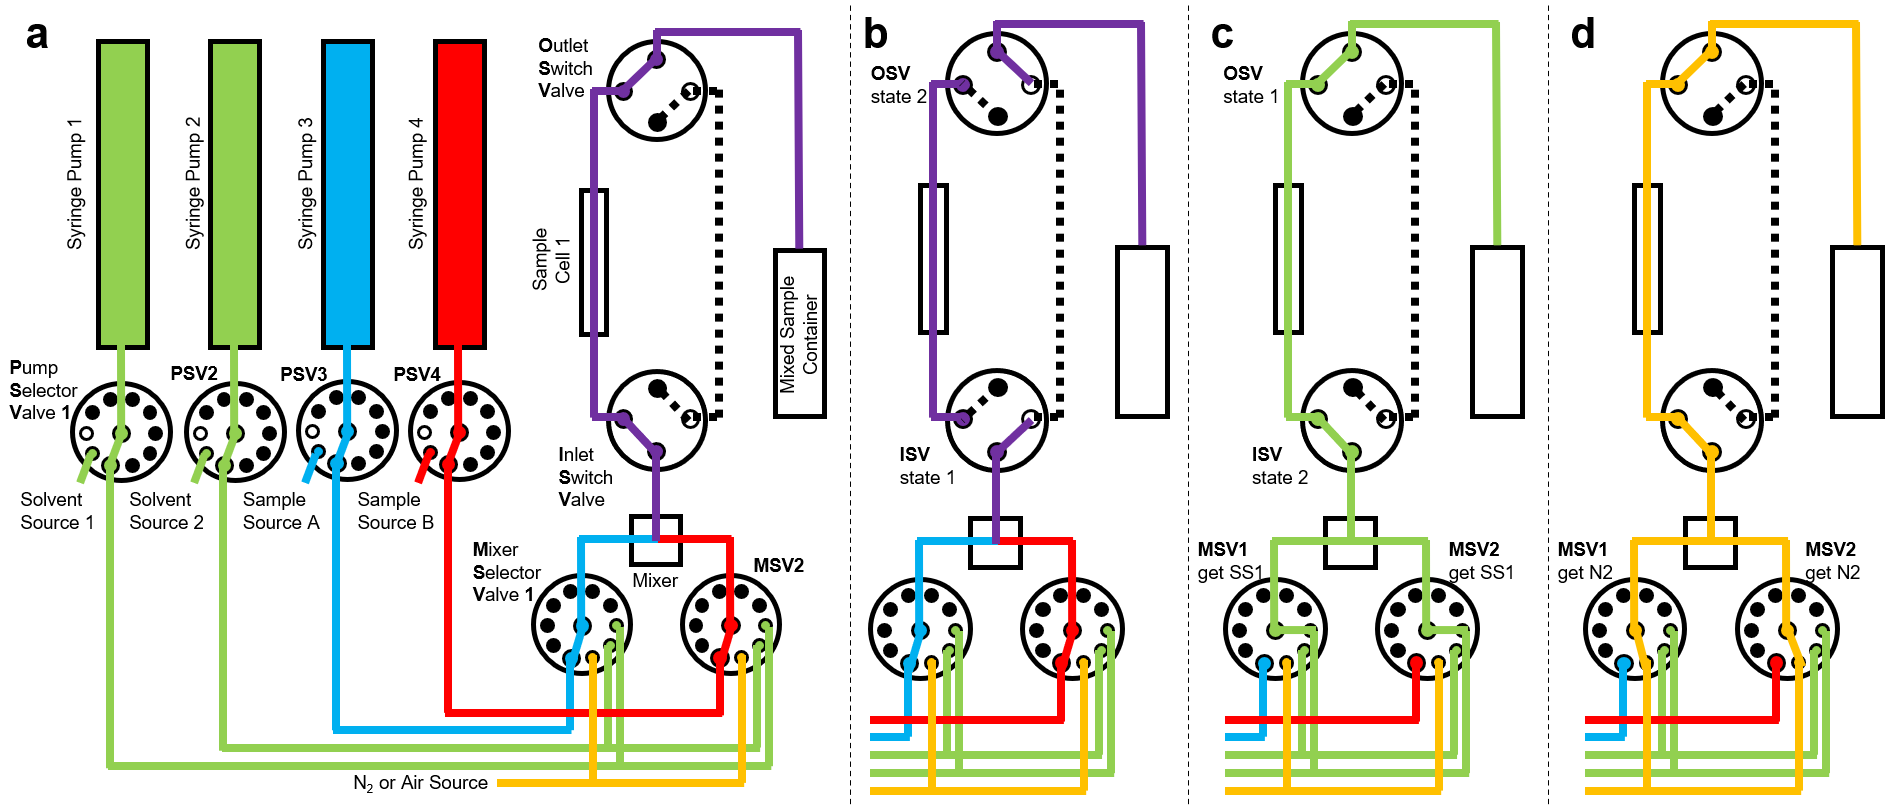

### 3a. Check ports and connections <a class="anchor" id="step3a"></a>

Double check that the port numbers associated in the flow selector <code>valve.setPort()</code> and <code>valve.getPort()</code> are  represented by the physically tube connections made at the valve ports. An example flow connection diagram is given above in (a). The port numbers and states are assigned according to the numbering in the figure below. The number proceeds like a clock face (starting with port 1 in the upper right-most port and proceeding clockwise around). The physical valve will have the port numbers labeled near the tubing connection.

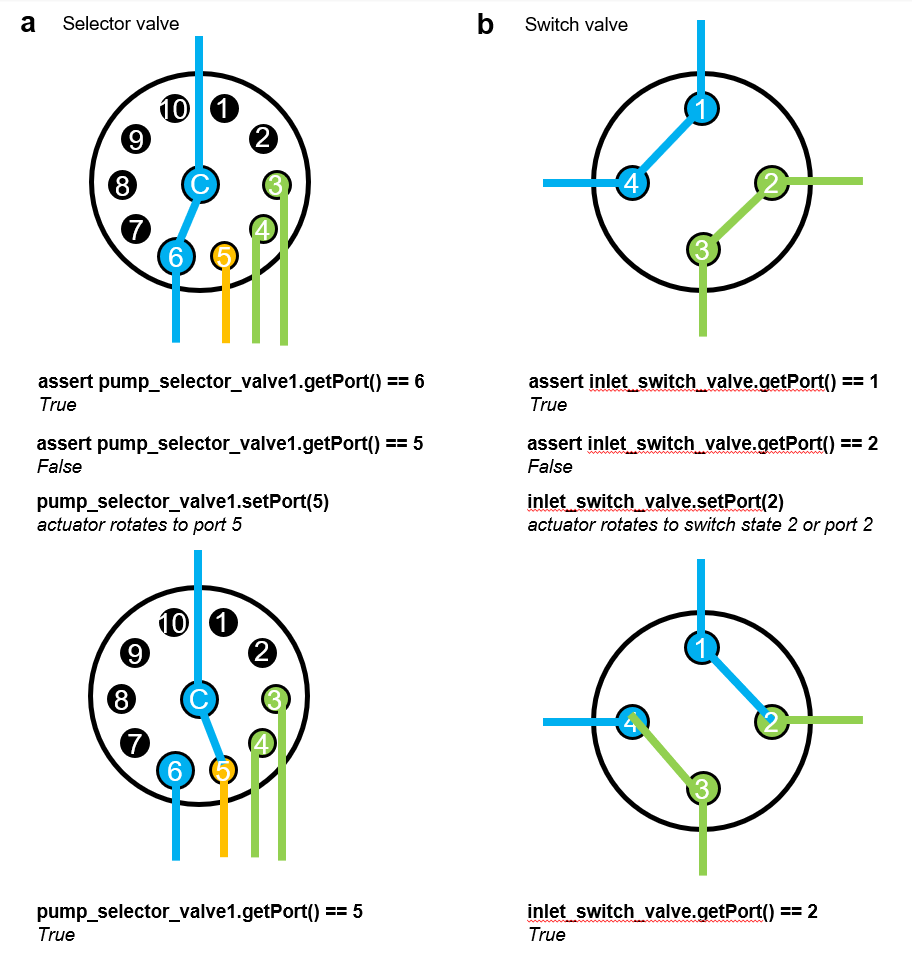

In the example of the 10-port VICI selector valve in (a), notice that after switching from port <code>6</code> to port <code>5</code>, the internal valve volume of channels connecting the center port <code>C</code> still contains liquid from port <code>6</code>. The valve must be flushed from the new source (port <code>5</code>) if one does not want back mixing between remnants of port <code>6</code> into the port <code>5</code> stream. Other closed (plugged, black filled) ports can be selected to prevent back mixing. Open ports (open to atmosphere, no fill) can be used to vent air or liquid pressure.

In the example of a 4-port VICI switch valve shown in (b), notice thatport <code>1</code> never connects to port <code>3</code>. Likewise, port <code>2</code> never connects to port <code>4</code>. This logic is true for both switch state 1 (top) and switch state 2 (bottom), which are the switch states set by using the object method <code>inlet_switch_valve.setPort(1)</code> and <code>inlet_switch_valve.setPort(2)</code>, respectively.

The experiment procedure below will use the above connection diagram assuming the following port connections (refer to the two diagrams above):

<b>pump_selector_valve1 (PSV1)</b>
<ol>  
    <li> Port <code>1</code> closed (plugged)
    <li> Port <code>2</code> closed (plugged)
    <li> Port <code>3</code> closed (plugged)
    <li> Port <code>4</code> closed (plugged)
    <li> Port <code>5</code> closed (plugged)
    <li> Port <code>6</code> connected to MSV1 Port 3 and MSV2 Port 3
    <li> Port <code>7</code> connected to Solvent Source 1 (SS1)
    <li> Port <code>8</code> open (not plugged)
    <li> Port <code>9</code> closed (plugged)
    <li> Port <code>10</code> closed (plugged)
    <li> Port <code>C</code> connected to pump1
</ol>

<b>pump_selector_valve2 (PSV2)</b>
<ol>  
    <li> Port <code>1</code> closed (plugged)
    <li> Port <code>2</code> closed (plugged)
    <li> Port <code>3</code> closed (plugged)
    <li> Port <code>4</code> closed (plugged)
    <li> Port <code>5</code> closed (plugged)
    <li> Port <code>6</code> connected to MSV1 Port 4 and MSV2 Port 4
    <li> Port <code>7</code> connected to Solvent Source 2 (SS2)
    <li> Port <code>8</code> open (not plugged)
    <li> Port <code>9</code> closed (plugged)
    <li> Port <code>10</code> closed (plugged)
    <li> Port <code>C</code> connected to pump2
</ol>

<b>pump_selector_valve3 (PSV3)</b>
<ol>  
    <li> Port <code>1</code> closed (plugged)
    <li> Port <code>2</code> closed (plugged)
    <li> Port <code>3</code> closed (plugged)
    <li> Port <code>4</code> closed (plugged)
    <li> Port <code>5</code> closed (plugged)
    <li> Port <code>6</code> connected to MSV1 Port 6
    <li> Port <code>7</code> connected to Sample Source A (SSA)
    <li> Port <code>8</code> open (not plugged)
    <li> Port <code>9</code> closed (plugged)
    <li> Port <code>10</code> closed (plugged)
    <li> Port <code>C</code> connected to pump3
</ol>

<b>pump_selector_valve4 (PSV4)</b>
<ol>  
    <li> Port <code>1</code> closed (plugged)
    <li> Port <code>2</code> closed (plugged)
    <li> Port <code>3</code> closed (plugged)
    <li> Port <code>4</code> closed (plugged)
    <li> Port <code>5</code> closed (plugged)
    <li> Port <code>6</code> connected to MSV2 Port 6
    <li> Port <code>7</code> connected to Sample Source B (SSB)
    <li> Port <code>8</code> open (not plugged)
    <li> Port <code>9</code> closed (plugged)
    <li> Port <code>10</code> closed (plugged)
    <li> Port <code>C</code> connected to pump4
</ol>

<b>mixer_selector_valve1 (MSV1)</b>
<ol>  
    <li> Port <code>1</code> closed (plugged)
    <li> Port <code>2</code> closed (plugged)
    <li> Port <code>3</code> connected to PSV1 Port 6 (injects Solvent Source 1)
    <li> Port <code>4</code> connected to PSV2 Port 6 (injects Solvent Source 2)
    <li> Port <code>5</code> connected to Nitrogen gas line or pure air source
    <li> Port <code>6</code> connected to PSV3 Port 7 (injects Sample Source A)
    <li> Port <code>7</code> closed (plugged)
    <li> Port <code>8</code> closed (plugged)
    <li> Port <code>9</code> closed (plugged)
    <li> Port <code>10</code> closed (plugged)
    <li> Port <code>C</code> connected to Mixer inlet
</ol>

<b>mixer_selector_valve2 (MSV2)</b>
<ol>  
    <li> Port <code>1</code> closed (plugged)
    <li> Port <code>2</code> closed (plugged)
    <li> Port <code>3</code> connected to PSV1 Port 6 (injects Solvent Source 1)
    <li> Port <code>4</code> connected to PSV2 Port 6 (injects Solvent Source 2)
    <li> Port <code>5</code> connected to Nitrogen gas line or pure air source
    <li> Port <code>6</code> connected to PSV4 Port 7 (injects Sample Source B)
    <li> Port <code>7</code> closed (plugged)
    <li> Port <code>8</code> closed (plugged)
    <li> Port <code>9</code> closed (plugged)
    <li> Port <code>10</code> closed (plugged)
    <li> Port <code>C</code> connected to Mixer inlet
</ol>

<b>inlet_switch_valve (ISV)</b>
<ol>  
    <li> Port <code>1</code> closed (plugged)
    <li> Port <code>2</code> connected to OSV2
    <li> Port <code>3</code> connected to Mixer outlet
    <li> Port <code>4</code> connected to Sample Cell 1 inlet
</ol>

<b>outlet_switch_valve (OSV)</b>
<ol>  
    <li> Port <code>1</code> connected to Mixed Sample Container
    <li> Port <code>2</code> connected to ISV2
    <li> Port <code>3</code> closed (plugged)
    <li> Port <code>4</code> connected to Sample Cell 1 outlet
</ol>

### 3b. Calculate the void volumes <a class="anchor" id="step3b"></a>

The relevant void volumes include any open volume existing between (and including) the mixing chamber and the outlet of the sample cell. Given this total void volume $V_{void}$ between the point of mixing and the point of SANS measurement, and given the total sample flow rate $Q_{total}$, the delay time $t_{delay}$ is simply the residence time given by $t_{delay} = V_{void}/Q_{total}$

In [ ]:
#Mixer void volume
mixer_void_mL=0.150 #mL

#Mixer outlet tubing void volume
ID_tubing_mixer_outlet_mm = 0.5 #mm
L_tubing_mixer_outlet_mm = 60 #mm
tubing_mixer_outlet_void_mL = 3.14 / 4 * ID_tubing_mixer_outlet_mm**2 * L_tubing_mixer_outlet_mm / 1000

#Inlet switch valve void volume
inlet_switch_valve_void_mL=0.05 #mL

#Sample cell void volume
ID_tubing_cell_inlet_mm = 0.5 #mm
L_tubing_cell_inlet_mm = 50 #mm
tubing_mixer_out_void_mL = 3.14 / 4 * ID_tubing_mixer_out_mm**2 * L_tubing_mixer_out_mm / 1000
W_cell_1_mm = 2 #mm
D_cell_1_mm = 2 #mm
H_cell_1_mm = 40 #mm
cell_1_void_mL = W_cell_1_mm * D_cell_1_mm * H_cell_1_mm / 1000

#Total void volume
void_volume_mL = mixer_void_mL + tubing_mixer_outlet_void_mL + inlet_switch_valve_void_mL + cell_1_void_mL #mL

### 3c. Priming pumps with sample, solvent, or buffer <a class="anchor" id="step3c"></a>

Define the priming parameters below

In [ ]:
#priming
#volumes to be filled initially to prime the syringes
SSA_fill_volume_mL = 5 #mL
SSB_fill_volume_mL = 5 #mL
SS1_fill_volume_mL = 10 #mL
SS2_fill_volume_mL = 10 #mL
#flow rates when filling syringes
SSA_fill_rate_mLmin = 5 #mL/min
SSB_fill_rate_mLmin = 5 #mL/min
SS1_fill_rate_mLmin = 10 #mL/min
SS2_fill_rate_mLmin = 10 #mL/min


Start the filling and priming of the solvent and sample syringes

In [ ]:
#set valves to their solvent or sample sources


#check valves moved


#start filling syringes
print('Initial syringe fill starting...')

pump1.aspirate(volume=SS1_fill_volume_mL-pump1.get_fill_level(), flow=SS1_fill_rate_mLmin)
pump2.aspirate(volume=SS2_fill_volume_mL-pump2.get_fill_level(), flow=SS2_fill_rate_mLmin)
pump3.aspirate(volume=SSA_fill_volume_mL-pump3.get_fill_level(), flow=SSA_fill_rate_mLmin)
pump4.aspirate(volume=SSB_fill_volume_mL-pump4.get_fill_level(), flow=SSB_fill_rate_mLmin)

print('Syringes filled and ready for air purging')

### 3d. Purging air from pump, valves, tubing, mixer, and sample cells <a class="anchor" id="step3d"></a>

Define the purging parameters below

In [ ]:
#purging
#volumes to be dispensed to purge out any unwanted air in the syringes, valves, and lines
SSA_purge_volume_mL = 0.5 #mL
SSB_purge_volume_mL = 0.5 #mL
SS1_purge_volume_mL = 3 #mL
SS2_purge_volume_mL = 3 #mL
#flow rates when purging syringes and lines
SSA_purge_rate_mLmin = 5 #mL/min
SSB_purge_rate_mLmin = 5 #mL/min
SS1_purge_rate_mLmin = 5 #mL/min
SS2_purge_rate_mLmin = 5 #mL/min

Start the sequential purging of each syringe, valve, and tubing connections between the syringes and the mixer

In [ ]:
print('Starting syringe priming.')

for iteration_count in range(1, priming_cycles+1, 1):
    print('Starting priming cycle:', iteration_count)
    
    #check pumps are enabled**
    
    #check pumps are not pumping for some reason
    assert pump0.is_pumping() == False
    assert pump1.is_pumping() == False
    assert pump2.is_pumping() == False
    assert pump3.is_pumping() == False

    #move valves
    valve_S1.selectPort(2)
    valve_S2.selectPort(2)
    valve_LP1.selectPort(8)
    valve_LP2.selectPort(8)
    valve_HP1.selectPort(1, direction='CCW') #make this go counter clockwise (CCW)
    valve_HP2.selectPort(1, direction='CW') #make this go clockwise (CW)

    #confirm valves moved to correct position
    time.sleep(valve_time_sec)
    assert valve_S1.getPort() == 2
    assert valve_S2.getPort() == 2
    assert valve_LP1.getPort() == 8
    assert valve_LP2.getPort() == 8
    assert valve_HP1.getPort() == 1
    assert valve_HP2.getPort() == 1

    #fill sample A, sample B, solvent 1, solvent 2
    print('Filling sample A, sample B, solvent 1, solvent 2.')
    pump0.aspirate(volume=(S1_fill_volume_mL-pump0.get_fill_level()), flow=S1_fill_rate_mLmin)
    pump1.aspirate(volume=(S2_fill_volume_mL-pump1.get_fill_level()), flow=S2_fill_rate_mLmin)
    pump2.aspirate(volume=(A_fill_volume_mL-pump2.get_fill_level()), flow=A_fill_rate_mLmin)
    pump3.aspirate(volume=(B_fill_volume_mL-pump3.get_fill_level()), flow=B_fill_rate_mLmin)
    #add a timestamp here
    assert pump0.is_pumping() == True
    assert pump1.is_pumping() == True
    assert pump2.is_pumping() == True
    assert pump3.is_pumping() == True

    time.sleep(S1_fill_volume_mL / S1_fill_rate_mLmin * 60 + buffer_time_sec)
    time.sleep(wait_time_sec)
    
    #add timestamp here
    assert pump0.is_pumping() == False
    assert pump1.is_pumping() == False
    assert pump2.is_pumping() == False
    assert pump3.is_pumping() == False
    
    #move valves
    valve_S1.selectPort(1)
    valve_S2.selectPort(1)
    valve_LP1.selectPort(7)
    valve_LP2.selectPort(7)
    valve_HP1.selectPort(3, direction='CCW') #make this go counter clockwise (CCW)
    valve_HP2.selectPort(3, direction='CW') #make this go clockwise (CW)

    #confirm valves moved to correct position
    time.sleep(valve_time_sec)
    assert valve_S1.getPort() == 1
    assert valve_S2.getPort() == 1
    assert valve_LP1.getPort() == 7
    assert valve_LP2.getPort() == 7
    assert valve_HP1.getPort() == 3
    assert valve_HP2.getPort() == 3
    
    #purge solvent 1, solvent 2
    print('Purging solvent 1, solvent 2.')
    pump0.aspirate(volume=(S1_fill_volume_mL-pump0.get_fill_level()), flow=S1_fill_rate_mLmin)
    pump1.aspirate(volume=(S2_fill_volume_mL-pump1.get_fill_level()), flow=S2_fill_rate_mLmin)

    #add a timestamp here
    assert pump0.is_pumping() == True
    assert pump1.is_pumping() == True
    time.sleep(S1_fill_volume_mL / S1_fill_rate_mLmin * 60 + buffer_time_sec)
    assert pump0.is_pumping() == False
    assert pump1.is_pumping() == False

    
    #move valves
    valve_S1.selectPort(1)
    valve_S2.selectPort(1)
    valve_LP1.selectPort(7)
    valve_LP2.selectPort(7)
    valve_HP1.selectPort(1) #make this go counter clockwise (CCW)
    valve_HP2.selectPort(1) #make this go clockwise (CW)

    #confirm valves moved to correct position
    time.sleep(valve_time_sec)
    assert valve_S1.getPort() == 1
    assert valve_S2.getPort() == 1
    assert valve_LP1.getPort() == 7
    assert valve_LP2.getPort() == 7
    assert valve_HP1.getPort() == 3
    assert valve_HP2.getPort() == 3
    #purge solvent 1, solvent 2
    
    print('Purging sample A, sample B.')
    pump2.aspirate(volume=(A_fill_volume_mL-pump2.get_fill_level()), flow=A_fill_rate_mLmin)
    pump3.aspirate(volume=(B_fill_volume_mL-pump3.get_fill_level()), flow=B_fill_rate_mLmin)
    
    assert pump2.is_pumping() == True
    assert pump3.is_pumping() == True
    time.sleep(S1_fill_volume_mL / S1_fill_rate_mLmin * 60 + buffer_time_sec)
    assert pump2.is_pumping() == False
    assert pump3.is_pumping() == False
    
    
    #wait for experiment time to end
    #add timestamp here
    #add timestamp here

print('Solvent and sample lines primed and purged.')

# 4. Stopped-flow experiment procedure <a class="anchor" id="step4"></a>

### 4a. Define and test the rinsing/drying protocol before sample injection <a class="anchor" id="step4a"></a>

In [ ]:
rinse_dry_cycles = 3
valve_time_sec = 3
dry_time_short_sec = 10
dry_time_long_sec = 120
SS1_fill_volume_mL = 10
SS2_fill_volume_mL = 10

In this rinse/drying protocol, the mixer and sample cell is rinsed 3 times with Solvent Source 1, then 3 times with a 50/50 mixture of Solvent Source 1 and Solvent Source 2, then 3 times with Solvent Source 2. A short drying step occurs between each solvent injection. A final longer drying step is done at after the 9 solvent rinses. Modify the parameters above and procedure below for your desired rinsing protocol.

Test the rinsing protocol once before sample injection to ensure it works properly>

In [ ]:
#INITIAL DRY
print('Initial drying...')
#Dry stream with N2 briefly to remove channels of sample
#move valves
valve_S1.selectPort(2)
valve_S2.selectPort(2)
valve_LP1.selectPort(7)
valve_LP2.selectPort(7)
valve_HP1.selectPort(4) #make this go counter clockwise (CCW)
valve_HP2.selectPort(8) #make this go clockwise (CW)

#confirm valves moved to correct position
time.sleep(valve_time_sec)
assert valve_S1.getPort() == 2
assert valve_S2.getPort() == 2
assert valve_LP1.getPort() == 7
assert valve_LP2.getPort() == 7
assert valve_HP1.getPort() == 4
assert valve_HP2.getPort() == 8
time.sleep(dry_time_short_sec)
print('Initial drying complete.')


for rinse_dry_count in range(1, rinse_dry_cycles+1, 1):
    
    print('Starting rinsing with water:', rinse_dry_count)
    
    #INJECT
    #move valves
    valve_S1.selectPort(1)
    valve_S2.selectPort(1)
    valve_LP1.selectPort(7)
    valve_LP2.selectPort(7)
    valve_HP1.selectPort(3) #make this go counter clockwise (CCW)
    valve_HP2.selectPort(9) #make this go clockwise (CW)
    #confirm valves moved to correct position
    time.sleep(valve_time_sec)
    assert valve_S1.getPort() == 1
    assert valve_S2.getPort() == 1
    assert valve_LP1.getPort() == 7
    assert valve_LP2.getPort() == 7
    assert valve_HP1.getPort() == 3
    assert valve_HP2.getPort() == 9
    #inject water
    print('Injecting...')
    pump0.dispense(volume=1, flow=10)
    #pump1.dispense(volume=1, flow=10)
    assert pump0.is_pumping() == True
    #assert pump1.is_pumping() == True
    while pump0.is_pumping() == True:
        time.sleep(3)
    #while pump1.is_pumping() == True:
    #    time.sleep(3)
    assert pump0.is_pumping() == False
    #assert pump1.is_pumping() == False
    print('Injecting complete.')
    
    #DRY
    print('Drying...')
    #move valves
    valve_S1.selectPort(2)
    valve_S2.selectPort(2)
    valve_LP1.selectPort(7)
    valve_LP2.selectPort(7)
    valve_HP1.selectPort(4) #make this go counter clockwise (CCW)
    valve_HP2.selectPort(8) #make this go clockwise (CW)
    #confirm valves moved to correct position
    time.sleep(valve_time_sec)
    assert valve_S1.getPort() == 2
    assert valve_S2.getPort() == 2
    assert valve_LP1.getPort() == 7
    assert valve_LP2.getPort() == 7
    assert valve_HP1.getPort() == 4
    assert valve_HP2.getPort() == 8
    #wait for dry
    time.sleep(dry_time_short_sec)
    print('Drying complete.')
    
    #REFILL
    #move valves
    valve_S1.selectPort(2)
    valve_S2.selectPort(2)
    valve_LP1.selectPort(7)
    valve_LP2.selectPort(7)
    valve_HP1.selectPort(3) #make this go counter clockwise (CCW)
    valve_HP2.selectPort(9) #make this go clockwise (CW)
    #confirm valves moved to correct position
    time.sleep(valve_time_sec)
    assert valve_S1.getPort() == 2
    assert valve_S2.getPort() == 2
    assert valve_LP1.getPort() == 7
    assert valve_LP2.getPort() == 7
    assert valve_HP1.getPort() == 3
    assert valve_HP2.getPort() == 9
    #refill solvent syringes #update this to fill to desired “fill volume” from current get_fill_level
    print('Refilling...')
    pump0.aspirate(volume=S1_fill_volume_mL-pump0.get_fill_level(), flow=10)
    #pump1.aspirate(volume=S2_fill_volume_mL-pump1.get_fill_level(), flow=10)
    assert pump0.is_pumping() == True
    #assert pump1.is_pumping() == True
    while pump0.is_pumping() == True:
        time.sleep(3)
    #while pump1.is_pumping() == True:
    #    time.sleep(3)
    assert pump0.is_pumping() == False
    #assert pump1.is_pumping() == False
    print('Refilling complete.')

    
#INITIAL DRY
print('Initial drying...')
#Dry stream with N2 briefly to remove channels of sample
#move valves
valve_S1.selectPort(2)
valve_S2.selectPort(2)
valve_LP1.selectPort(7)
valve_LP2.selectPort(7)
valve_HP1.selectPort(4) #make this go counter clockwise (CCW)
valve_HP2.selectPort(8) #make this go clockwise (CW)

#confirm valves moved to correct position
time.sleep(valve_time_sec)
assert valve_S1.getPort() == 2
assert valve_S2.getPort() == 2
assert valve_LP1.getPort() == 7
assert valve_LP2.getPort() == 7
assert valve_HP1.getPort() == 4
assert valve_HP2.getPort() == 8
time.sleep(dry_time_short_sec)
print('Initial drying complete.')
    
for rinse_dry_count in range(1, rinse_dry_cycles+1, 1):
    
    print('Starting rinsing with water and ethanol:', rinse_dry_count)
    
    #INJECT
    #move valves
    valve_S1.selectPort(1)
    valve_S2.selectPort(1)
    valve_LP1.selectPort(7)
    valve_LP2.selectPort(7)
    valve_HP1.selectPort(3) #make this go counter clockwise (CCW)
    valve_HP2.selectPort(9) #make this go clockwise (CW)
    #confirm valves moved to correct position
    time.sleep(valve_time_sec)
    assert valve_S1.getPort() == 1
    assert valve_S2.getPort() == 1
    assert valve_LP1.getPort() == 7
    assert valve_LP2.getPort() == 7
    assert valve_HP1.getPort() == 3
    assert valve_HP2.getPort() == 9
    #inject water and ethanol
    print('Injecting...')
    pump0.dispense(volume=1, flow=10)
    pump1.dispense(volume=1, flow=10)
    assert pump0.is_pumping() == True
    assert pump1.is_pumping() == True
    while pump0.is_pumping() == True:
        time.sleep(3)
    while pump1.is_pumping() == True:
        time.sleep(3)
    assert pump0.is_pumping() == False
    assert pump1.is_pumping() == False
    print('Injecting complete.')
    
    #DRY
    print('Drying...')
    #move valves
    valve_S1.selectPort(2)
    valve_S2.selectPort(2)
    valve_LP1.selectPort(7)
    valve_LP2.selectPort(7)
    valve_HP1.selectPort(4) #make this go counter clockwise (CCW)
    valve_HP2.selectPort(8) #make this go clockwise (CW)
    #confirm valves moved to correct position
    time.sleep(valve_time_sec)
    assert valve_S1.getPort() == 2
    assert valve_S2.getPort() == 2
    assert valve_LP1.getPort() == 7
    assert valve_LP2.getPort() == 7
    assert valve_HP1.getPort() == 4
    assert valve_HP2.getPort() == 8
    #wait for dry
    time.sleep(dry_time_short_sec)
    print('Drying complete.')
    
    #REFILL
    #move valves
    valve_S1.selectPort(2)
    valve_S2.selectPort(2)
    valve_LP1.selectPort(7)
    valve_LP2.selectPort(7)
    valve_HP1.selectPort(3) #make this go counter clockwise (CCW)
    valve_HP2.selectPort(9) #make this go clockwise (CW)
    #confirm valves moved to correct position
    time.sleep(valve_time_sec)
    assert valve_S1.getPort() == 2
    assert valve_S2.getPort() == 2
    assert valve_LP1.getPort() == 7
    assert valve_LP2.getPort() == 7
    assert valve_HP1.getPort() == 3
    assert valve_HP2.getPort() == 9
    #refill solvent syringes #update this to fill to desired “fill volume” from current get_fill_level
    print('Refilling...')
    pump0.aspirate(volume=S1_fill_volume_mL-pump0.get_fill_level(), flow=10)
    pump1.aspirate(volume=S2_fill_volume_mL-pump1.get_fill_level(), flow=10)
    assert pump0.is_pumping() == True
    assert pump1.is_pumping() == True
    while pump0.is_pumping() == True:
        time.sleep(3)
    while pump1.is_pumping() == True:
        time.sleep(3)
    assert pump0.is_pumping() == False
    assert pump1.is_pumping() == False
    print('Refilling complete.')

#INITIAL DRY
print('Initial drying...')
#Dry stream with N2 briefly to remove channels of sample
#move valves
valve_S1.selectPort(2)
valve_S2.selectPort(2)
valve_LP1.selectPort(7)
valve_LP2.selectPort(7)
valve_HP1.selectPort(4) #make this go counter clockwise (CCW)
valve_HP2.selectPort(8) #make this go clockwise (CW)

#confirm valves moved to correct position
time.sleep(valve_time_sec)
assert valve_S1.getPort() == 2
assert valve_S2.getPort() == 2
assert valve_LP1.getPort() == 7
assert valve_LP2.getPort() == 7
assert valve_HP1.getPort() == 4
assert valve_HP2.getPort() == 8
time.sleep(dry_time_short_sec)
print('Initial drying complete.')
    
for rinse_dry_count in range(1, rinse_dry_cycles+1, 1):
    
    print('Starting rinsing with ethanol:', rinse_dry_count)
    
    #INJECT
    #move valves
    valve_S1.selectPort(1)
    valve_S2.selectPort(1)
    valve_LP1.selectPort(7)
    valve_LP2.selectPort(7)
    valve_HP1.selectPort(3) #make this go counter clockwise (CCW)
    valve_HP2.selectPort(9) #make this go clockwise (CW)
    #confirm valves moved to correct position
    time.sleep(valve_time_sec)
    assert valve_S1.getPort() == 1
    assert valve_S2.getPort() == 1
    assert valve_LP1.getPort() == 7
    assert valve_LP2.getPort() == 7
    assert valve_HP1.getPort() == 3
    assert valve_HP2.getPort() == 9
    #inject ethanol
    print('Injecting...')
    #pump0.dispense(volume=1, flow=10)
    pump1.dispense(volume=1, flow=10)
    #assert pump0.is_pumping() == True
    assert pump1.is_pumping() == True
    #while pump0.is_pumping() == True:
    #    time.sleep(3)
    while pump1.is_pumping() == True:
        time.sleep(3)
    #assert pump0.is_pumping() == False
    assert pump1.is_pumping() == False
    print('Injecting complete.')
    
    #DRY
    print('Drying...')
    #move valves
    valve_S1.selectPort(2)
    valve_S2.selectPort(2)
    valve_LP1.selectPort(7)
    valve_LP2.selectPort(7)
    valve_HP1.selectPort(4) #make this go counter clockwise (CCW)
    valve_HP2.selectPort(8) #make this go clockwise (CW)
    #confirm valves moved to correct position
    time.sleep(valve_time_sec)
    assert valve_S1.getPort() == 2
    assert valve_S2.getPort() == 2
    assert valve_LP1.getPort() == 7
    assert valve_LP2.getPort() == 7
    assert valve_HP1.getPort() == 4
    assert valve_HP2.getPort() == 8
    #wait for dry
    time.sleep(dry_time_short_sec)
    print('Drying complete.')
    
    #REFILL
    #move valves
    valve_S1.selectPort(2)
    valve_S2.selectPort(2)
    valve_LP1.selectPort(7)
    valve_LP2.selectPort(7)
    valve_HP1.selectPort(3) #make this go counter clockwise (CCW)
    valve_HP2.selectPort(9) #make this go clockwise (CW)
    #confirm valves moved to correct position
    time.sleep(valve_time_sec)
    assert valve_S1.getPort() == 2
    assert valve_S2.getPort() == 2
    assert valve_LP1.getPort() == 7
    assert valve_LP2.getPort() == 7
    assert valve_HP1.getPort() == 3
    assert valve_HP2.getPort() == 9
    #refill solvent syringes #update this to fill to desired “fill volume” from current get_fill_level
    print('Refilling...')
    #pump0.aspirate(volume=S1_fill_volume_mL-pump0.get_fill_level(), flow=10)
    pump1.aspirate(volume=S2_fill_volume_mL-pump1.get_fill_level(), flow=10)
    #assert pump0.is_pumping() == True
    assert pump1.is_pumping() == True
    #while pump0.is_pumping() == True:
    #    time.sleep(3)
    while pump1.is_pumping() == True:
        time.sleep(3)
    #assert pump0.is_pumping() == False
    assert pump1.is_pumping() == False
    print('Refilling complete.')
    

#FINAL DRY
print('Final drying...')
#Dry stream with N2 briefly to remove channels of sample
#move valves
valve_S1.selectPort(2)
valve_S2.selectPort(2)
valve_LP1.selectPort(7)
valve_LP2.selectPort(7)
valve_HP1.selectPort(4) #make this go counter clockwise (CCW)
valve_HP2.selectPort(8) #make this go clockwise (CW)

#confirm valves moved to correct position
time.sleep(valve_time_sec)
assert valve_S1.getPort() == 2
assert valve_S2.getPort() == 2
assert valve_LP1.getPort() == 7
assert valve_LP2.getPort() == 7
assert valve_HP1.getPort() == 4
assert valve_HP2.getPort() == 8
time.sleep(dry_time_long_sec)
print('Final dry complete.')

### 4b. Define all stopped-flow parameters <a class="anchor" id="step4b"></a>

Input the timing paramters, volume paramters, and flow rate parameters for the stopped-flow experiment, as well as any purging and refilling procedures to be operating parallel with the data collection

In [ ]:
total_iterations = 3
experiment_time_sec = 5 #seconds
buffer_time_sec = 1 #seconds
valve_time_sec = 3 #seconds
dry_time_sec = 5 #seconds
refill_level_mL = 0.2 #mL
timeout_sec = 30 #seconds
rinse_dry_cycles = 3

SS1_purge_volume_mL = 0.1 #mL
SS2_purge_volume_mL = 0.1 #mL
SSA_purge_volume_mL = 0.1 #mL
SSB_purge_volume_mL = 0.1 #mL

SS1_injection_volume_mL = 2 #mL
SS2_injection_volume_mL = 2 #mL
SSA_injection_volume_mL = 0.2 #mL+
SSB_injection_volume_mL = SSA_injection_volume_mL

SS1_injection_rate_mLmin = 60 #mL/min
SS2_injection_rate_mLmin = 60 #mL/min
SSA_injection_rate_mLmin = 60 #mL/min
SSB_injection_rate_mLmin = SSA_injection_rate_mLmin

SS1_refill_rate_mLmin = 10 #mL/min
SS2_refill_rate_mLmin = 10 #mL/min
SSA_refill_rate_mLmin = 10 #mL/min
SSB_refill_rate_mLmin = 10 #mL/min

### 4c. Start SANS event mode data collection <a class="anchor" id="step4c"></a>

Start event mode data collection using the NICE software on the SANS instrument computer

Start the SANS data acquisition using the NICE software on the SANS instrument computer with the pre-determined experiment configuration, detector distances, neutron wavelength, and neutron guides. SANS configurations will be set up by instrument scientists at the NCNR.

After the SANS data acquisition has started, proceed with starting the stopped-flow experiment below

### 4d. Start the stopped-flow mixing experiment <a class="anchor" id="step4d"></a>

In [ ]:
print('Starting experiment.')

for iteration_count in range(1, total_iterations+1, 1):
    print('Starting iteration:', iteration_count)
    
    #check pumps are not pumping for some reason
    assert pump0.is_pumping() == False
    assert pump1.is_pumping() == False
    assert pump2.is_pumping() == False
    assert pump3.is_pumping() == False

    #move valves
    valve_S1.selectPort(1)
    valve_S2.selectPort(1)
    valve_LP1.selectPort(1)
    valve_LP2.selectPort(1)
    valve_HP1.selectPort(1, direction='CCW') #make this go counter clockwise (CCW)
    valve_HP2.selectPort(1, direction='CW') #make this go clockwise (CW)

    #confirm valves moved to correct position
    time.sleep(valve_time_sec)
    assert valve_S1.getPort() == 1
    #assert valve_S2.getPort() == 1
    assert valve_LP1.getPort() == 1
    assert valve_LP2.getPort() == 1
    assert valve_HP1.getPort() == 1
    assert valve_HP2.getPort() == 1

    #inject A and B samples
    print('Injecting A and B.')
    pump2.dispense(volume=A_injection_volume_mL, flow=A_injection_rate_mLmin)
    pump3.dispense(volume=B_injection_volume_mL, flow=B_injection_rate_mLmin)
    #add a timestamp here
    assert pump2.is_pumping() == True
    assert pump3.is_pumping() == True

    time.sleep(A_injection_volume_mL / A_injection_rate_mLmin * 60 + buffer_time_sec)
    
    #add timestamp here
    assert pump2.is_pumping() == False
    assert pump3.is_pumping() == False

    #close valves after pumping stops
    valve_HP1.selectPort(2) #make this go clockwise
    valve_HP2.selectPort(2) #make this go clockwise
    #add timestamp here
    time.sleep(valve_time_sec)
    assert valve_HP1.getPort() == 2
    assert valve_HP2.getPort() == 2

    #wait for experiment time to end
    #add timestamp here
    time.sleep(experiment_time_sec) #seconds
    print('Finishing experiment iteration', iteration_count)
    #add timestamp here


    #establish nested for loop based on rinse_dry_cycles

    for rinse_dry_count in range(1, rinse_dry_cycles+1, 1):
        print('Starting rinsing:', rinse_dry_count)
        
        #move valves
        valve_S1.selectPort(1)
        valve_S2.selectPort(1)
        #valve_LP1.selectPort(3) #refill sample A if necessary here, check get_fill_level < refill_level
        #valve_LP2.selectPort(3) #refill sample B if necessary here, check get_fill_level < refill_level
        valve_HP1.selectPort(3) #make this go clockwise
        valve_HP2.selectPort(3) #make this go clockwise

        #confirm valves moved to correct position
        time.sleep(valve_time_sec)
        assert valve_S1.getPort() == 1
        assert valve_S2.getPort() == 1
        assert valve_LP1.getPort() == 1
        assert valve_LP2.getPort() == 1
        assert valve_HP1.getPort() == 3
        assert valve_HP2.getPort() == 3

        #inject S1 and purge S2
        pump0.dispense(volume=S1_injection_volume_mL, flow=S1_injection_rate_mLmin)
        pump1.dispense(volume=S2_purge_volume_mL, flow=S2_injection_rate_mLmin)
        assert pump0.is_pumping() == True
        assert pump1.is_pumping() == True
        time.sleep(S1_injection_volume_mL / S1_injection_rate_mLmin * 60 + buffer_time_sec)
        assert pump0.is_pumping() == False
        assert pump1.is_pumping() == False

        #inject S2
        pump1.dispense(volume=S2_injection_volume_mL, flow=S2_injection_rate_mLmin)
        assert pump1.is_pumping() == True
        time.sleep(S2_injection_volume_mL / S2_injection_rate_mLmin * 60 + buffer_time_sec)
        assert pump1.is_pumping() == False

        #move valves to air dry mixer and cell, and to fill solvent syringes
        valve_S1.selectPort(2)
        valve_S2.selectPort(2)
        valve_LP1.selectPort(1)
        valve_LP2.selectPort(1)
        valve_HP1.selectPort(4)
        valve_HP2.selectPort(4)

        #confirm valves moved to correct position
        time.sleep(valve_time_sec)
        assert valve_S1.getPort() == 2
        assert valve_S2.getPort() == 2
        assert valve_LP1.getPort() == 1
        assert valve_LP2.getPort() == 1
        assert valve_HP1.getPort() == 4
        assert valve_HP2.getPort() == 4

        #refill solvent syringes #update this to fill to desired “fill volume” from current get_fill_level
        pump0.aspirate(volume=S1_injection_volume_mL, flow=S1_refill_rate_mLmin)
        pump1.aspirate(volume=S2_injection_volume_mL+S2_purge_volume_mL, flow=S2_refill_rate_mLmin)
        assert pump0.is_pumping() == True
        assert pump1.is_pumping() == True
        #add something here to wait for pump0 or pump1, whichever is slower, while loop instead of assert
        time.sleep(S2_injection_volume_mL / S2_refill_rate_mLmin * 60 + buffer_time_sec) #seconds
        assert pump0.is_pumping() == False
        assert pump1.is_pumping() == False

        #continue to wait for mixer, cell, and lines to dry
        time.sleep(dry_time_sec)
        
        #repeat for rince_dry_cycles
        print('Finishing rinsing:', rinse_dry_count)

        
    #repeat back to sample injection of A and B
    print('Finishing iteration:', iteration_count)

print('Experiment complete.')


### 4e. Collect SANS transmission measurement

Prior to rinsing the sample out after the very last repition, be sure to collect a SANS transmission measurement. The transmission measurement is required to reduce the data to an absolute intensity scale. A transmission measurement (100 s collection time) should be collected for each unique mixed sample composition. Tranmission strongly depends on the incident neutron wavelength and the detector configuration. Tranmission depends on the sample density, and as such is a weak function of temperature.

After at least one transmission measurement is collected, procede with the rinsing procedures, stopped-flow experiment, or shutdown procedures.

# 5. Time binning event mode data <a class="anchor" id="step5"></a>

### 5a. Import event data for SANS .nxs file <a class="anchor" id="step5a"></a>

### 5b. Plot the time-stamped neutron counts <a class="anchor" id="step5b"></a>

### 5c. Define time bin edges and bin the data<a class="anchor" id="step5c"></a>

### 5d. Reduced the time binned data using SANS reduction procedures <a class="anchor" id="step5d"></a>

# 6. Shutdown <a class="anchor" id="step6"></a>
Skip this step if you intend to load different syringes (Step 2) or different samples (Step 3)


In [ ]:
bus.stop()
bus.close()